# Coolstore Evaluation

In this notebook, we evaluate the value proposition of Kai. Kai uses additional data from Konveyor Hub (solved examples), static code analysis as well as the rules themselves to augment an LLM prompt to get better quality responses. This is in contrast to using an LLM directly with little or no specific information in the prompts.

We will work with Kai to provide fixes for issues identified in [Coolstore](https://github.com/konveyor-ecosystem/coolstore) app for different kinds of issues. The fixes for these issues involve varying levels of complexity. For each issue, we try to evaluate the responses under two conditions - with and without supplemental information from the analysis. In the supplemental analysis information, we will permute between text description about issues, previous solved examples, static code analysis information, etc.

Finally, we will compare how well Kai does compared to zero-shot prompts.

For evaluating the responses, we will be using another LLM to evaluate based on a well defined criteria. More about details of evaluation later.

## Pre-requisites

To run snippets in this notebook, you first need to set up Kai's virtualenv in the [base dir](../../).

Activate the virtualenv and install the Jupyter kernel for it:

```sh
python -m ipykernel install --user --name=<your-venv-dir>
```

We also need an additional package for plotting charts which we will install in our environment:

```sh
pip install matplotlib
```

Once installed, you should be able to use your Kai venv for this notebook. In VsCode, this can be done in the upper right corner. 

Then, create a `.env` file in the [base dir](../../) that contains export commands to source your LLM access keys:

```sh
export GENAI_KEY=<your-ibm-key>
export OPENAI_API_KEY=<your-openai-key>
```

We use IBM and OpenAI models in our experiments by default. However, you can configure which models to use further ahead when we create config files for the models. In that case, you can skip the keys for models you don't need. 

To configure which models to use to generate fixes, update the `KAI_FIX_MODELS` list in the following cell:

In [2]:
# some shorthands we can use in our experiments for different models
META_LLAMA_13b = 'meta-llama-13b'
META_LLAMA_70b = 'meta-llama-70b'
MIXTRAL = 'mixtral'
IBM_GRANITE = 'ibm-granite'
GPT_4 = "gpt-4"
GPT_3 = "gpt-3"
CLAUDE_SONNET = "sonnet-3-5"

# models used to generate kai-fix
KAI_FIX_MODELS = [
    META_LLAMA_13b,
    META_LLAMA_70b,
    IBM_GRANITE,
    MIXTRAL,
    GPT_3,
    GPT_4,
]

We use Claude Sonnet provided via AWS Bedrock for evaluation. You can choose to use GPT instead. When using Bedrock, make sure you have AWS credentials in your default aws profile. Update the `EVALUATION_MODEL` variable in the following cell to `GPT_4` to use gpt.

In [3]:
EVALUATION_MODEL = CLAUDE_SONNET

Run the following cell to load your `.env` file in notebook env.

In [4]:
%load_ext dotenv
%dotenv

Now, we will parse the analysis output to load the data into memory we need for the experiments. Continue running the cells in sequence one-by-one to advance.

In [5]:
# first we load incidents into memory and group by files for better access

import sys
sys.path.append('../../../kai')
from kai.models.report import Report

output_file = './analysis_output.yaml'
report = Report.load_report_from_file(output_file)
files = report.get_impacted_files()

# we filter out filepaths for dependencies
to_delete = []
for k in files: 
    if k.startswith('root/.m2'): to_delete.append(k)
for d in to_delete: del(files[d])

# printing file names and incidents in each file
for f in files: print(len(files[f]), f)

1 src/main/webapp/WEB-INF/web.xml
12 pom.xml
10 src/main/java/com/redhat/coolstore/model/Order.java
6 src/main/java/com/redhat/coolstore/model/OrderItem.java
5 src/main/webapp/WEB-INF/beans.xml
8 src/main/resources/META-INF/persistence.xml
6 src/main/java/com/redhat/coolstore/model/InventoryEntity.java
1 src/main/java/com/redhat/coolstore/model/ShoppingCart.java
6 src/main/java/com/redhat/coolstore/persistence/Resources.java
9 src/main/java/com/redhat/coolstore/rest/CartEndpoint.java
8 src/main/java/com/redhat/coolstore/rest/OrderEndpoint.java
3 src/main/java/com/redhat/coolstore/rest/ProductEndpoint.java
4 src/main/java/com/redhat/coolstore/rest/RestApplication.java
8 src/main/java/com/redhat/coolstore/service/CatalogService.java
2 src/main/java/com/redhat/coolstore/service/InventoryNotificationMDB.java
8 src/main/java/com/redhat/coolstore/service/OrderService.java
15 src/main/java/com/redhat/coolstore/service/OrderServiceMDB.java
3 src/main/java/com/redhat/coolstore/service/ProductSe

From the files displayed above, we will be focusing on following files in our experiments:

* src/main/java/com/redhat/coolstore/model/ShoppingCart.java (1 issue)
* src/main/java/com/redhat/coolstore/service/ShoppingCartOrderProcessor.java (10 issues)

Both of these files appear in our demo example found [here](https://github.com/konveyor/kai/blob/main/docs/scenarios/demo.md)

The difficulty levels involved in fixing these files are different.

* Easy example [ShoppingCart.java](https://github.com/konveyor-ecosystem/coolstore/blob/main/src/main/java/com/redhat/coolstore/model/ShoppingCart.java)
  * This file only has 1 migration issue. And it can be fixed by changing one import to a Quarkus compatible import. The underlying API itself doesn't require any change.
* Hard example [ShoppingCartOrderProcessor.java](https://github.com/konveyor-ecosystem/coolstore/blob/main/src/main/java/com/redhat/coolstore/service/ShoppingCartOrderProcessor.java)
  * This file has 10 issues most of which involve replacing import statements from `javax` to `jakarta`.
  * There are two issues that require changing an annotation to a quarkus compatible annotation.
  * However, there is one change in this file that involves replacing JMS Topic with an Emitter. This is a code rewrite thats more than just doing a string replace.

Now, we will clone the example app. The following cell will create a `data` directory to contain all the data we will generate when running experiments.

In [6]:
# now we will get our test data
import os
import errno
from git import Repo
import importlib

def ensure_dirs(dir):
    try:
        os.makedirs(dir)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

def clone_coolstore(branch: str, path: str):
    try:
        Repo.clone_from("https://github.com/konveyor-ecosystem/coolstore", 
            depth=1, single_branch=True, branch=branch, to_path=path)
    except Exception as e:
        if "already exists" not in str(e):
            print("fatal error cloning repo")
            sys.exit(1)

ensure_dirs("./data/apps/coolstore/")
clone_coolstore("quarkus", "./data/apps/coolstore/quarkus")
clone_coolstore("main", "./data/apps/coolstore/javaee")

Next, we will compile our analysis data as well as source code of affected files into a data structure for accessing later. We will also load the 3 examples we discussed earlier into variables so we can access them later.

In [12]:
# now we will create data required for evaluation
from datetime import datetime
from kai.evaluation import BenchmarkExample, evaluate
from kai.service.incident_store import Application

examples = {}
for f in files:
    original_content = ""
    expected_content = ""
    with open(f"./data/apps/coolstore/javaee/{f}", "r") as fl: original_content = fl.read()
    if os.path.exists(f"./data/apps/coolstore/quarkus/{f}"): 
        with open(f"./data/apps/coolstore/quarkus/{f}", "r") as fl: expected_content = fl.read()
    examples[f] = BenchmarkExample(
        application=Application(
            application_name="coolstore",
            current_branch="main",
            repo_uri_local="./data/apps/coolstore/javaee",
            generated_at=datetime.strptime("24/05/09 19:32:00", "%y/%m/%d %H:%M:%S"),
            repo_uri_origin="https://github.com/konveyor-ecosystem/coolstore",
            current_commit="aa"
        ),
        expected_file=expected_content,
        incidents=files[f],
        original_file=original_content,
        name=os.path.basename(f),
        report=report,
    )

EXAMPLE_EASY = examples['src/main/java/com/redhat/coolstore/model/ShoppingCart.java']
EXAMPLE_HARD = examples['src/main/java/com/redhat/coolstore/service/ShoppingCartOrderProcessor.java']

We will create some config files (in-memory) which we need to run Kai.

In [99]:
from jinja2 import Template

CONFIG_BASE_PATH = "./data/configs/"
OUTPUT_BASE_PATH = "./data/outputs/"

ensure_dirs(CONFIG_BASE_PATH)
ensure_dirs(OUTPUT_BASE_PATH)

templ = Template("""
trace_enabled = true
demo_mode = false
log_dir = "$pwd/logs"
file_log_level = "debug"
log_level = "info"

solution_consumers = {{ solution_consumers | default(["diff_only"]) }}

[models]
provider = "{{ model_provider }}"
template = "{{ prompt_template }}"

[models.args]
{% if model_provider == "ChatOpenAI" %}
model = "{{ model_id }}"
{% else %}
model_id = "{{ model_id }}"
{% endif %}
{% if max_tokens != "" %}
parameters.max_new_tokens = "{{ max_tokens }}"
{% endif %}

[incident_store]
solution_detectors = "naive"
solution_producers = {{ solution_producers | default("text_only") }}

[incident_store.args]
provider = "postgresql"
host = "127.0.0.1"
database = "kai"
user = "kai"
password = "dog8code"
""")

# model_provider: { model_id: {parameter: val}}
models = {
    "ChatIBMGenAI": {
        "meta-llama/llama-3-70b-instruct": {"max_tokens": "2048", "key": META_LLAMA_70b},
        "meta-llama/llama-2-13b-chat": {"max_tokens": "1536", "key": META_LLAMA_13b},
        "mistralai/mixtral-8x7b-instruct-v01": {"key": MIXTRAL},
        "ibm/granite-13b-chat-v2": {"key": IBM_GRANITE},
    },
    "ChatOpenAI": {
        "gpt-3.5-turbo": {"key": GPT_3},
        "gpt-4o": {"key": GPT_4},
    },
}

configs = {}

# create configs for all models with different parameters 
# we will use these as needed in our experiments
for model_provider, model_ids in models.items():
    for model_id, parameters in model_ids.items():
        configs[parameters.get("key", "")] = Template(templ.render(
            model_provider = model_provider,
            model_id = model_id,
            max_tokens = parameters.get("max_tokens", ""),
            prompt_template = "{{ prompt_template }}",
            solution_consumers = '{{ solution_consumers | default(["diff_only"]) }}',
            solution_producers = '"{{ solution_producers | default(\"text_only\") }}"'
        ))

The following cell contains some common code we will be using for experiments. There is no output for the cell, just run it before moving forward.

In [89]:
# this is common code we will use to evaluate response of LLM for one example
import json
import signal
import requests
import threading
import subprocess
import numpy as np
from time import sleep
import matplotlib.pyplot as plt
from kai.models.kai_config import KaiConfig
from jinja2 import Environment, FileSystemLoader
from kai.routes.get_incident_solutions_for_file import (
    PostGetIncidentSolutionsForFileParams,
)

if EVALUATION_MODEL == CLAUDE_SONNET:
    from langchain_aws import ChatBedrock
else:
    from langchain_openai import ChatOpenAI

# helper function to send requests to Kai service
def generate_fix(log: any, params: PostGetIncidentSolutionsForFileParams) -> dict:
    retries_left = 6
    for i in range(retries_left):
        try:
            headers = {"Content-type": "application/json", "Accept": "text/plain"}
            response = requests.post(
                "http://0.0.0.0:8080/get_incident_solutions_for_file",
                data=params.model_dump_json(),
                headers=headers,
                timeout=3600,
            )
            if response.status_code == 200:
                result = response.json()
                if isinstance(result, str):
                    return json.loads(result)
                elif isinstance(result, dict):
                    return result
                else:
                    return {}
            else:
                log.write(f"[{params.file_name}] Received status code {response.status_code}")
        except requests.exceptions.RequestException as e:
            log.write(f"[{params.file_name}] Received exception from Kai server: {e}")
        log.write(f"[{params.file_name}] Failed to get a '200' response from the server.  Retrying {retries_left-i} more times")
    raise(Exception(f"[{params.file_name}] Failed to get a '200' response from the server.  Parameters = {params}"))


# write a Kai config to a known location 
def ensure_config(model_key: str, experiment_key: str, prompt_template: str, llm_summary: bool = False) -> tuple[str, str]:
    ensure_dirs(f"{CONFIG_BASE_PATH}{experiment_key}")
    config_path = f"{CONFIG_BASE_PATH}{experiment_key}/{model_key}.toml"
    if llm_summary:
        config = configs[model_key].render(prompt_template=prompt_template, solution_producers='"llm_lazy"', solution_consumers=['llm_summary'])
    else:
        config = configs[model_key].render(prompt_template=prompt_template)
    with open(config_path, "w+") as f: f.write(config)
    config_parsed = KaiConfig.model_validate_filepath(config_path)
    return config_path, config_parsed

# run Kai service, this is used when we use Kai service instead of evaluate.py for generating fixes
def ensure_kai_service(output_path: str) -> tuple[list, list]:
    processes = []
    def run_command(cmd: str, stdout: any): 
        p = subprocess.Popen(cmd, shell=True, cwd="../../", 
            env=os.environ.copy(), stdout=stdout, stderr=stdout)
        processes.append(p)
        p.wait()
    ensure_dirs(f"{output_path}")
    postgres_log = open(f"{output_path}/postgres.log", "w+")
    db_thread  = threading.Thread(target=run_command, args=("DROP_TABLES=true POSTGRES_RUN_ARGS=--rm make run-postgres", postgres_log, ))
    kai_log = open(f"{output_path}/kai.log", "w+")
    kai_thread = threading.Thread(target=run_command, args=("DEMO_MODE=false make run-server", kai_log, ))
    db_thread.start()
    data_load_log = open(f"{output_path}/data_load.log", "w+")
    subprocess.run(["make", "load-data"], cwd="../../", stdout=data_load_log, stderr=data_load_log)
    kai_thread.start()
    return processes, [kai_log, postgres_log, data_load_log]

# helper function to kill processes gracefully, needed to clean up Kai service and db
def kill(processes: list):
    for p in processes:
        p.send_signal(signal.SIGINT)
        p.send_signal(signal.SIGTERM)

# this function runs "evaluate" function from evaluation.py and compares LLM responses with expected output to get edit distance
def run_evaluate_for_example(model_key: str, experiment_key: str, prompt_template: str, example: BenchmarkExample):
    config_path, config_parsed = ensure_config(model_key, experiment_key, prompt_template)
    full_response = evaluate(configs={config_path: config_parsed}, examples={example.name: example})
    response = full_response[(example.name, config_path)]
    output_path = f"{OUTPUT_BASE_PATH}/using_evaluation/{experiment_key}/{model_key}"
    ensure_dirs(output_path)
    with open(f"{output_path}/llm_response", "w+") as f: f.write(response.llm_result)
    with open(f"{output_path}/edit_distance", "w+") as f: f.write(f"{response.similarity}")
    with open(f"{output_path}/updated_file", "w+") as f: f.write(f"{response.updated_file}")

# this function sends example in a query to Kai service to get LLM response
def run_kai_generate_fix(model_key: str, experiment_key: str, prompt_template: str, example: BenchmarkExample, llm_summary: bool = False):
    output_path = f"{OUTPUT_BASE_PATH}/using_kai/{experiment_key}/{model_key}"
    ensure_dirs(output_path)
    runner_log = open(f"{output_path}/runner.log", "w+")
    config_path, config_parsed = ensure_config(model_key, experiment_key, os.path.basename(prompt_template), llm_summary)
    subprocess.run(['cp', f'../../kai/config.toml', f'../../kai/config.toml.temp'])
    subprocess.run(['cp', f'{config_path}', f'../../kai/config.toml'])
    subprocess.run(['cp', f'{prompt_template}', f'../../kai/data/templates/'])
    processes, logs = ensure_kai_service(output_path=output_path)
    # sleep is needed to let Kai server come up
    sleep(10)
    try:
        params = PostGetIncidentSolutionsForFileParams(
            application_name=example.application.application_name,
            file_contents=example.original_file,
            file_name=example.name,
            include_llm_results=False,
            incidents=example.incidents,
        )
        response = generate_fix(runner_log, params)
        if not response: 
            raise(f"failed to parse response")
        with open(f"{output_path}/llm_reasoning", "w+") as f: f.write(response.get('total_reasoning', [''])[0])
        with open(f"{output_path}/prompt", "w+") as f: f.write(response.get('used_prompts', [''])[0])
        with open(f"{output_path}/updated_file", "w+") as f: f.write(response.get('updated_file', ['']))
    except Exception as e:
        runner_log.write(f"failed to generate fix {e}")
    finally:
        # clean up
        subprocess.run(['rm', f'../../kai/data/templates/{os.path.basename(prompt_template)}'])
        subprocess.run(['mv', f'../../kai/config.toml.temp', f'../../kai/config.toml'])
        kill(processes)
        # sleep is needed to gracefully shutdown
        sleep(10)
        runner_log.close()
        for log in logs: log.close()
    pass

evaluation_criteria = {
    0: 'Issue Fixed?',
    1: 'General syntax correct?',
    2: 'Suitable for Quarkus?',
}

template_env = Environment(
    loader=FileSystemLoader(searchpath="./templates/"))

# function to evaluate updated file generated with kai using gpt-4 
def evaluate_with_gpt(key: str, example: BenchmarkExample, updated_file: str) -> str:    
    t = template_env.get_template("evaluate.jinja").render(
        incidents=example.incidents, original_file=example.original_file, 
        updated_file=updated_file)
    if EVALUATION_MODEL == CLAUDE_SONNET:
        llm = ChatBedrock(model_id="anthropic.claude-3-5-sonnet-20240620-v1:0")
    else:
        llm = ChatOpenAI(model_name="gpt-4o")
    output = llm.invoke(t)
    return output.content

# parses evaluation output
def parse_evaluation_output(output: str) -> tuple[list[int], list[str]]:
    ratings = []
    reasoning = []
    for idx, line in enumerate(output.strip('\n').strip('```').replace("\n\n", "\n").split("\n")):
        if idx % 2 == 0:
            ratings.append(float(line))
        else:
            reasoning.append(line)
    return ratings, reasoning

def plot_evaluation_score(data: dict):
    keys = list(data.keys())
    values = np.array(list(data.values()))
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(keys, values)
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
    ax.set_ylim(0, 5)
    ax.set_xlabel('Models')
    ax.set_ylabel('Score')
    ax.set_title('Evaluation Score by Model')
    fig.tight_layout()
    plt.show()

def plot_multibar_chart(data: list[tuple[dict, str]]):
    labels = [label for _, label in data]
    models = list(data[0][0].keys())
    fig, ax = plt.subplots()
    for model in models:
        model_values = [results[model] for results, _ in data]
        ax.plot(labels, model_values, marker='o', label=model)
    ax.set_xlabel('Experiments')
    ax.set_ylabel('Scores')
    ax.set_title('Model Performance by Experiment')
    ax.legend(loc='center left', bbox_to_anchor=(1, 1))
    plt.subplots_adjust(right=0.75)
    ax.legend()
    plt.show()

# given raw evaluation output from models, plots the chart and prints reasoning 
def plot_chart_and_print_reasoning(eval_output: dict):
    data = {}
    for model in KAI_FIX_MODELS:
        data[model] = parse_evaluation_output(eval_output[model])
    plot_evaluation_score({k: np.average(v[0], weights=[0.6, 0.3, 0.1]) for k, v in data.items()})
    for model in KAI_FIX_MODELS:
        print(f"{'* '}{model}")
        for idx, reasoning in enumerate(data[model][1]):
            print(f"\t{idx+1}. {reasoning}")

# given multiple eval outputs, plots a chart side-by-side for comparison
def plot_multibar_chart_from_eval_outputs(eval_outputs: list[tuple[dict, str]]):
    data_list = []
    for eval_output, label in eval_outputs:
        data_per_model = {}
        for model in KAI_FIX_MODELS:
            data_per_model[model] = parse_evaluation_output(eval_output[model])
        data_list.append(({k: np.average(v[0], weights=[0.6, 0.3, 0.1]) for k, v in data_per_model.items()}, label))
    plot_multibar_chart(data_list)

def run_evaluation_for_models(models: list[str], example: BenchmarkExample, base_output_path: str) -> dict[str, tuple[int, str]]:
    eval_output = {}
    for model in models:
        updated_content = ""
        with open(f"{base_output_path}/{model}/updated_file", "r") as f: updated_content = f.read()
        eval_output[model] = evaluate_with_gpt(model, example, updated_content)
    return eval_output


## Zero Shot with No Analysis Information

In this section, we run our first experiment. The prompt we use will have NO analysis information in it. We will ask LLM to simply generate a fixed file without telling it any more information. This is our baseline. We will run this with different models. Find the prompt we use [here](./templates/zero_shot/example1.jinja).

### Easy example

Lets start with the easy example (1 fix, simple import replace).

We will run the following cell to run the easy example with different models. 

The outputs of this experiment will be generated in `./data/outputs/using_kai/zero_shot_easy/` directory for each model.

In [74]:
# run kai-fix for all models
for model in KAI_FIX_MODELS:
    print(f"generating fix using model {model}")
    run_kai_generate_fix(model, "zero_shot_easy", "./templates/zero_shot/default.jinja", EXAMPLE_EASY)
    print(f"generated fix using model {model}, output present in {OUTPUT_BASE_PATH}/using_kai/zero_shot_easy/{model}")

generating fix using model meta-llama-13b
generated fix using model meta-llama-13b, output present in ./data/outputs//using_kai/zero_shot_easy/meta-llama-13b
generating fix using model meta-llama-70b
generated fix using model meta-llama-70b, output present in ./data/outputs//using_kai/zero_shot_easy/meta-llama-70b
generating fix using model ibm-granite
generated fix using model ibm-granite, output present in ./data/outputs//using_kai/zero_shot_easy/ibm-granite
generating fix using model mixtral
generated fix using model mixtral, output present in ./data/outputs//using_kai/zero_shot_easy/mixtral
generating fix using model gpt-3
generated fix using model gpt-3, output present in ./data/outputs//using_kai/zero_shot_easy/gpt-3
generating fix using model gpt-4
generated fix using model gpt-4, output present in ./data/outputs//using_kai/zero_shot_easy/gpt-4


#### Evaluating LLM responses

Evaluating a fix using edit distance has been a challenge. LLMs are not predictable and they may sometimes fix more things than needed, not fix anything at all and/or introduce new issues. For instance, in the Easy Example, the only change that needs to happen is replace the `javax` import with `jakarta`. The edit distance between expected output and original output is already quite low. So if we get a lower edit distance, that doesn't tell us anything useful regarding the fix. We would still need to look at the output file to determine whether the issue was actually fixed. On the other hand, the Hard Example requires re-writing a part of the code. There may be more than one correct ways of re-writing the code. For instance, different LLMs can use different variable names, function signatures etc while still producing a valid output. The edit distance for all of them will be different since we will only ever compare the output with our version of correct output. In both of these scenarios, we cannot objectively tell whether the actual issues are fixed and whether the file is compatible with Quarkus after making those fixes. While edit distance is a much more consistent metric, it doesn't tell us anything about these specific concerns we have about the fix generated.

For these reasons, we use another smarter LLM to evaluate responses. In that, we will ask the LLM to rate the migrated file (updated file returned by Kai) based on a well defined criteria. There will be 3 main metrics in the criteria, each having a rating on a scale of 0 to 5. In all of these metrics, higher rating is better.

The metrics are:

1. Is LLM fixing the things that need to be fixed?

This metric tells whether LLM is doing changes than are required. We want the issues that we originally pointed out fixed in the final output. Also, we want specific changes, not unnecessary changes.

2. Is the Java file generally syntactically correct? 

With this metric, we focus on general syntactical correctness. We specifically evaluate whether all imports are correct, function signatures are correct, etc.

3. Is the final file suitable for Quarkus? Are there more changes needed to be done?

Here, we evaluate based on whether the final file is compatible with Quarkus. We also see if there were any new issues introduced in the file.

We don't care about all these metrics equally, so we take an weighted average with weights being 0.6, 0.3, 0.1 from top to bottom.

The assumption is that the LLM we use for evaluation is somewhat knowledgeable about Quarkus. Given a hint about the migration issue, it will be good enough to give us a high level picture of the quality of responses. Find our evaluation prompt [here](./templates/evaluation.jinja). 

We understand that this is not a perfect way to evaluate. But, we can improve on evaluation itself. We are not including any examples of evaluation in our prompt right now. We can include some relevant examples pertaining to issues in the file to get better evaluation results.

That being said, we are not interested in the exact ratings in evaluation. The goal is just to get an insight into how well a LLM performs when it is given additional information from incidents. That is where the magic of Kai happens. And conclusion we are looking for is whether that magic is really useful. So we will be only looking at evaluation results in a relative scale, rather than debating about specific ratings.

In [54]:
zero_shot_easy_eval_output = run_evaluation_for_models(KAI_FIX_MODELS, EXAMPLE_EASY, "./data/outputs/using_kai/zero_shot_easy")

Now that we have data from our first experiment, we will plot a bar chart. And also print reasoning behind each score our evaluation produced for different models.

Compare the reasoning with the actual file generated in [output directory](./data/outputs/using_kai/zero_shot_easy/) and see if you agree with the reasoning.

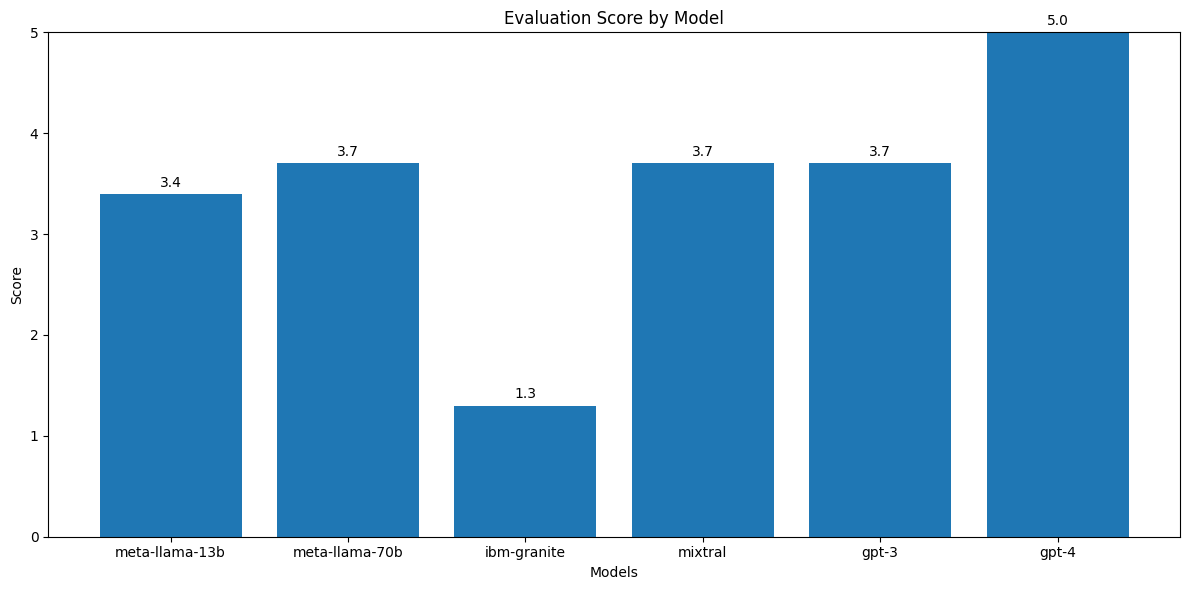

* meta-llama-13b
	1. The import statement for javax.enterprise was removed, but jakarta.enterprise was not added as requested. The @Dependent annotation was also removed without replacement.
	2. The updated file appears to be syntactically valid and can be compiled. However, some imports are missing (e.g., for @Entity, @Id, @GeneratedValue).
	3. The file is largely compatible with Quarkus, using JPA annotations for persistence. However, the missing jakarta.enterprise import and lack of CDI scope annotation (e.g., @ApplicationScoped) might cause issues in a Quarkus context.
* meta-llama-70b
	1. The issue of replacing javax.enterprise import with jakarta.enterprise was not addressed. However, the import and @Dependent annotation were removed entirely, which is a valid approach for Quarkus if the class doesn't need to be a CDI bean.
	2. The updated file is syntactically valid and can be compiled. All necessary imports are present, and the original functionality is maintained. The code has

In [56]:

plot_chart_and_print_reasoning(zero_shot_easy_eval_output)

If you look at the reasoning our evaluation model produced for each output, and compare that with the actual generated file, we can see that the scores rightly (somewhat) reflect the idea of "accuracy" of a certain fix. One important point to note here is that since this file only contained one issue, the evaluation output is pretty much binary (remember, we have the highest weight on metric 1 i.e. whether the issue is fixed or not). This won't be the case for more harder cases further ahead.

> Note that absolute rating numbers don't matter much. We are more interested in looking at how a model does relatively in different scenarios. Finally, we will be looking at the trend of how things improved as Kai added more and more contextual information to the prompt.

### Hard example

Now we will run the same experiment with a harder example. The fix for this file involves more than just changing an import.

The outputs of this experiment will be generated in `./data/outputs/using_kai/zero_shot_hard/` directory for each model.

In [20]:
# run kai-fix for all models
for model in KAI_FIX_MODELS:
    print(f"generating fix using model {model}")
    run_kai_generate_fix(model, "zero_shot_hard", "./templates/zero_shot/default.jinja", EXAMPLE_HARD)
    print(f"generated fix using model {model}, output present in {OUTPUT_BASE_PATH}/using_kai/zero_shot_hard/{model}")

generating fix using model meta-llama-13b
generated fix using model meta-llama-13b, output present in ./data/outputs//using_kai/zero_shot_hard/meta-llama-13b
generating fix using model meta-llama-70b
generated fix using model meta-llama-70b, output present in ./data/outputs//using_kai/zero_shot_hard/meta-llama-70b
generating fix using model ibm-granite
generated fix using model ibm-granite, output present in ./data/outputs//using_kai/zero_shot_hard/ibm-granite
generating fix using model mixtral
generated fix using model mixtral, output present in ./data/outputs//using_kai/zero_shot_hard/mixtral
generating fix using model gpt-3
generated fix using model gpt-3, output present in ./data/outputs//using_kai/zero_shot_hard/gpt-3
generating fix using model gpt-4
generated fix using model gpt-4, output present in ./data/outputs//using_kai/zero_shot_hard/gpt-4


Now we will run the evaluation.

In [59]:
zero_shot_hard_eval_output = run_evaluation_for_models(KAI_FIX_MODELS, EXAMPLE_HARD, "./data/outputs/using_kai/zero_shot_hard")

Now we plot the chart.

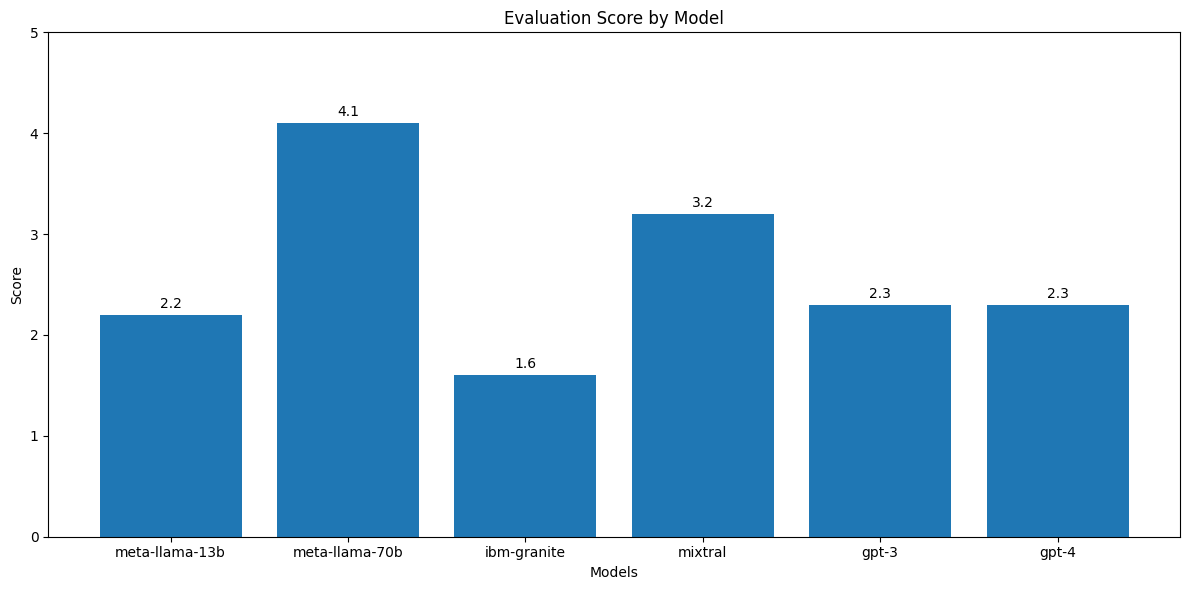

* meta-llama-13b
	1. While some issues were addressed (logging), many critical issues remain unresolved, including JMS replacement and annotation changes.
	2. The file is syntactically valid, but missing imports for annotations and incomplete implementation may cause compilation errors.
	3. The file still contains JavaEE elements (@Stateless) and lacks Quarkus-specific implementations, making it largely incompatible with Quarkus.
* meta-llama-70b
	1. Most issues are fixed, but the `@ApplicationScoped` annotation is missing, which was mentioned in incident 5.
	2. The file is syntactically valid and imports are correct. However, the `@ApplicationScoped` annotation should be added for proper scoping in Quarkus.
	3. The updated file is compatible with Quarkus, using appropriate Quarkus-specific APIs and annotations. It successfully replaces JMS with Reactive Messaging.
* ibm-granite
	1. The updated file only partially addresses the issues identified in the original JavaEE file. It fails to

In [60]:
plot_chart_and_print_reasoning(zero_shot_hard_eval_output)

## Zero Shot with analysis information

In this section, we run kai fix with a modified prompt. It will contain information about incidents in the file which will help pinpoint the issues in the file. We will run the exact same experiments we ran in the previous section.

Find the prompt used in this experiment [here](./templates/zero_shot/with_analysis_info.jinja)

### Easy example

This example only contains one issue which requires replacing an import.

The outputs of this experiment will be generated in `./data/outputs/using_kai/zero_shot_easy_with_info/` directory for each model.

In [129]:
# run kai-fix for all models
for model in KAI_FIX_MODELS:
    print(f"generating fix using model {model}")
    run_kai_generate_fix(model, "zero_shot_easy_with_info", "./templates/zero_shot/with_analysis_info.jinja", EXAMPLE_EASY)
    print(f"generated fix using model {model}, output present in {OUTPUT_BASE_PATH}/using_kai/zero_shot_easy_with_info/{model}")

generating fix using model meta-llama-13b
generated fix using model meta-llama-13b, output present in ./data/outputs//using_kai/zero_shot_easy_with_info/meta-llama-13b
generating fix using model meta-llama-70b
generated fix using model meta-llama-70b, output present in ./data/outputs//using_kai/zero_shot_easy_with_info/meta-llama-70b
generating fix using model ibm-granite
generated fix using model ibm-granite, output present in ./data/outputs//using_kai/zero_shot_easy_with_info/ibm-granite
generating fix using model mixtral
generated fix using model mixtral, output present in ./data/outputs//using_kai/zero_shot_easy_with_info/mixtral
generating fix using model gpt-3
generated fix using model gpt-3, output present in ./data/outputs//using_kai/zero_shot_easy_with_info/gpt-3
generating fix using model gpt-4
generated fix using model gpt-4, output present in ./data/outputs//using_kai/zero_shot_easy_with_info/gpt-4


Now let's evaluate the responses and plot the charts.

In [61]:
zero_shot_easy_with_info_eval_output = run_evaluation_for_models(KAI_FIX_MODELS, EXAMPLE_EASY, "./data/outputs/using_kai/zero_shot_easy_with_info")

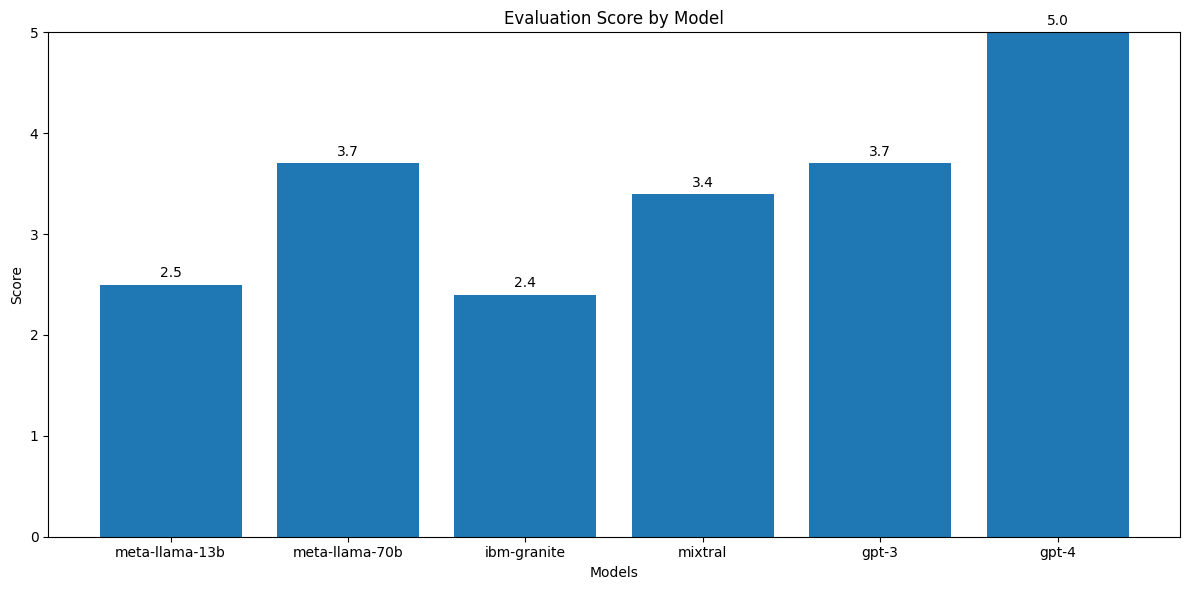

* meta-llama-13b
	1. The updated file partially addresses the issue by removing the javax.enterprise import, but it doesn't replace it with jakarta.enterprise as specified. The @Dependent annotation is replaced with @ApplicationScoped without explanation.
	2. The updated file is syntactically valid and can be compiled. However, it lacks necessary imports (e.g., for @ApplicationScoped and Serializable). The functionality seems to be mostly preserved, but there are unexplained changes to the ShoppingCartItem type.
	3. The updated file is generally compatible with Quarkus. The use of @ApplicationScoped is appropriate for Quarkus. However, the lack of proper imports and the unexplained changes to ShoppingCartItem could potentially cause issues in a Quarkus application.
* meta-llama-70b
	1. The issue of replacing javax.enterprise import with jakarta.enterprise was not addressed. However, the import and @Dependent annotation were removed entirely, which is a valid approach for Quarkus if the

In [62]:
plot_chart_and_print_reasoning(zero_shot_easy_with_info_eval_output)

### Hard example

Now we use a relatively harder example to evaluate responses.

The outputs of this experiment will be generated in `./data/outputs/using_kai/zero_shot_hard_with_info/` directory for each model.

In [21]:
# run kai-fix for all models
for model in KAI_FIX_MODELS:
    print(f"generating fix using model {model}")
    run_kai_generate_fix(model, "zero_shot_hard_with_info", "./templates/zero_shot/with_analysis_info.jinja", EXAMPLE_HARD)
    print(f"generated fix using model {model}, output present in {OUTPUT_BASE_PATH}/using_kai/zero_shot_hard_with_info/{model}")

generating fix using model meta-llama-13b
generated fix using model meta-llama-13b, output present in ./data/outputs//using_kai/zero_shot_hard_with_info/meta-llama-13b
generating fix using model meta-llama-70b
generated fix using model meta-llama-70b, output present in ./data/outputs//using_kai/zero_shot_hard_with_info/meta-llama-70b
generating fix using model ibm-granite
generated fix using model ibm-granite, output present in ./data/outputs//using_kai/zero_shot_hard_with_info/ibm-granite
generating fix using model mixtral
generated fix using model mixtral, output present in ./data/outputs//using_kai/zero_shot_hard_with_info/mixtral
generating fix using model gpt-3
generated fix using model gpt-3, output present in ./data/outputs//using_kai/zero_shot_hard_with_info/gpt-3
generating fix using model gpt-4
generated fix using model gpt-4, output present in ./data/outputs//using_kai/zero_shot_hard_with_info/gpt-4


Now we evaluate and plot the charts.

In [63]:
zero_shot_hard_with_info_eval_output = run_evaluation_for_models(KAI_FIX_MODELS, EXAMPLE_HARD, "./data/outputs/using_kai/zero_shot_hard_with_info")

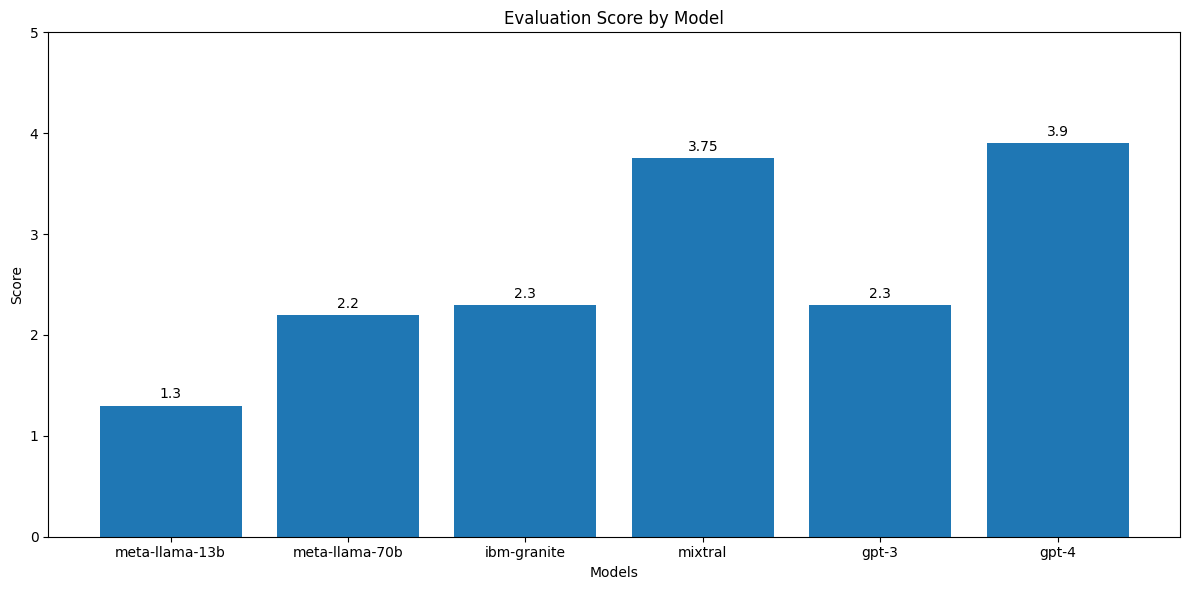

* meta-llama-13b
	1. Only 1 out of 10 issues has been addressed (importing Logger from Quarkus). Most JavaEE imports and annotations remain unchanged.
	2. The file is syntactically valid, but it's missing necessary imports for Quarkus-specific classes like io.quarkus.arc.inject.Inject.
	3. The file is still largely JavaEE-based and not suitable for Quarkus. It retains EJB annotations, JMS context, and Topic, which are not compatible with Quarkus.
* meta-llama-70b
	1. Some issues were fixed, but critical changes for Quarkus compatibility were not implemented.
	2. The file is syntactically valid, but missing important imports and annotations for Quarkus.
	3. The file is not suitable for Quarkus as it retains JMS elements and lacks necessary Quarkus-specific modifications.
* ibm-granite
	1. Only some of the identified issues were addressed. The javax to jakarta imports were not updated, and the @Stateless annotation wasn't replaced with @ApplicationScoped.
	2. The file appears syntactical

In [64]:
plot_chart_and_print_reasoning(zero_shot_hard_with_info_eval_output)

# Few Shot (Diff Only)

In this section, we will run the same examples but this time we will include solved examples in our prompts. 

We will start by including diff-only mode which includes diffs of solved examples in the input prompt directly.

## Easy example

For the easy example we are using, solved solutions data is not available in Kai at the time of writing this. Therefore, we create our own example to use that contains a diff of an already solved incident. The prompt we use is [here](./templates/few_shot/easy_hardcoded.jinja)

The outputs of this experiment will be generated in `./data/outputs/using_kai/few_shot_easy/` directory for each model.

In [100]:
# run kai-fix for all models
for model in KAI_FIX_MODELS:
    print(f"generating fix using model {model}")
    run_kai_generate_fix(model, "few_shot_easy", "./templates/few_shot/easy_hardcoded.jinja", EXAMPLE_EASY)
    print(f"generated fix using model {model}, output present in {OUTPUT_BASE_PATH}/using_kai/few_shot_easy/{model}")

generating fix using model meta-llama-13b
generated fix using model meta-llama-13b, output present in ./data/outputs//using_kai/few_shot_easy/meta-llama-13b
generating fix using model meta-llama-70b
generated fix using model meta-llama-70b, output present in ./data/outputs//using_kai/few_shot_easy/meta-llama-70b
generating fix using model ibm-granite


KeyboardInterrupt: 

Now we will evaluate the responses.

In [65]:
few_shot_easy_eval_output = run_evaluation_for_models(KAI_FIX_MODELS, EXAMPLE_EASY, "./data/outputs/using_kai/few_shot_easy")

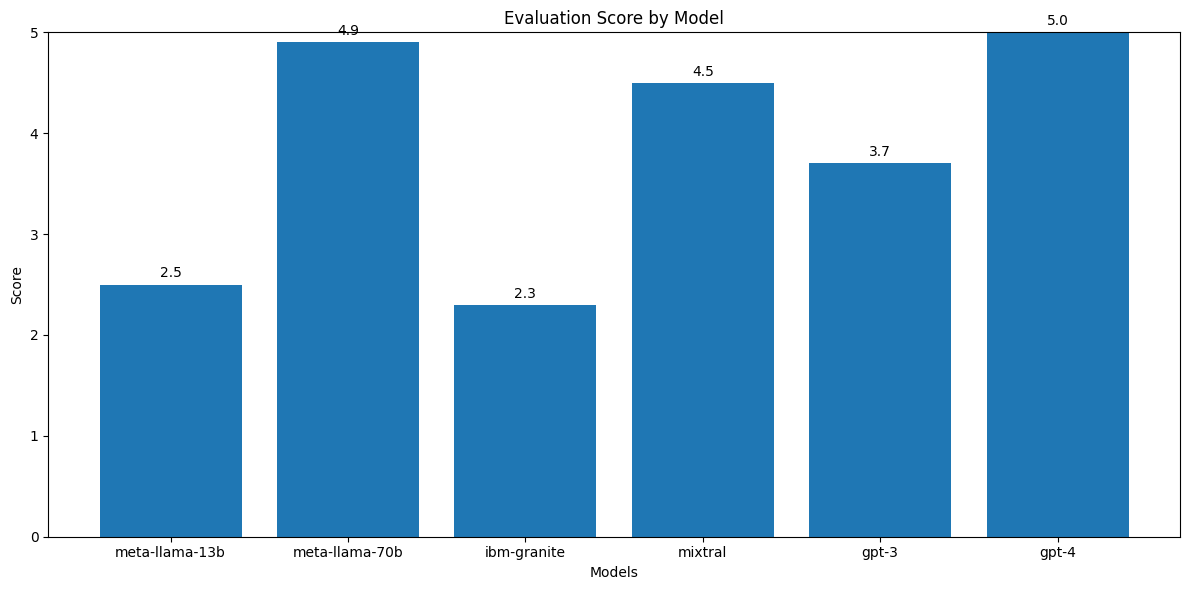

* meta-llama-13b
	1. The issue of replacing javax.enterprise with jakarta.enterprise is not addressed. The import has been removed entirely.
	2. The file is mostly syntactically valid, but there are missing imports (e.g., ArrayList). The @Dependent annotation has been removed without explanation.
	3. The file is largely compatible with Quarkus. The removal of @Dependent and use of @Log annotation (which is Quarkus-specific) improve compatibility. However, the missing imports may cause compilation issues.
* meta-llama-70b
	1. The issue of replacing the javax.enterprise import with jakarta.enterprise has been correctly addressed.
	2. The updated file is syntactically valid, all necessary imports are present, and the original functionality is preserved.
	3. The file is largely compatible with Quarkus. The @Dependent annotation was replaced with @ApplicationScoped, which is more appropriate for Quarkus. However, it's worth noting that @ApplicationScoped creates a singleton, which may not b

In [66]:
plot_chart_and_print_reasoning(few_shot_easy_eval_output)

## Hard example

Since this file contains many incidents, and most of these incidents have solved examples stored in Kai, we were hitting input limits when we used a prompt that contains solved examples for all of the incidents. Therefore, we are only going to use solved example for the most difficult issue in the file which is to change the JMS Topic to an emitter. This is the 7th incident. We will be using [this prompt](./templates/few_shot/default.jinja).

The outputs of this experiment will be generated in `./data/outputs/using_kai/few_shot_hard/` directory for each model.

In [27]:
# run kai-fix for all models
for model in KAI_FIX_MODELS:
    print(f"generating fix using model {model}")
    run_kai_generate_fix(model, "few_shot_hard", "./templates/few_shot/default.jinja", EXAMPLE_HARD)
    print(f"generated fix using model {model}, output present in {OUTPUT_BASE_PATH}/using_kai/few_shot_hard/{model}")

generating fix using model meta-llama-13b
generated fix using model meta-llama-13b, output present in ./data/outputs//using_kai/few_shot_hard/meta-llama-13b
generating fix using model meta-llama-70b
generated fix using model meta-llama-70b, output present in ./data/outputs//using_kai/few_shot_hard/meta-llama-70b
generating fix using model ibm-granite
generated fix using model ibm-granite, output present in ./data/outputs//using_kai/few_shot_hard/ibm-granite
generating fix using model mixtral
generated fix using model mixtral, output present in ./data/outputs//using_kai/few_shot_hard/mixtral
generating fix using model gpt-3
generated fix using model gpt-3, output present in ./data/outputs//using_kai/few_shot_hard/gpt-3
generating fix using model gpt-4
generated fix using model gpt-4, output present in ./data/outputs//using_kai/few_shot_hard/gpt-4


Now lets evaluate the responses we get from all models.

In [67]:
few_shot_hard_eval_output = run_evaluation_for_models(KAI_FIX_MODELS, EXAMPLE_HARD, "./data/outputs/using_kai/few_shot_hard")

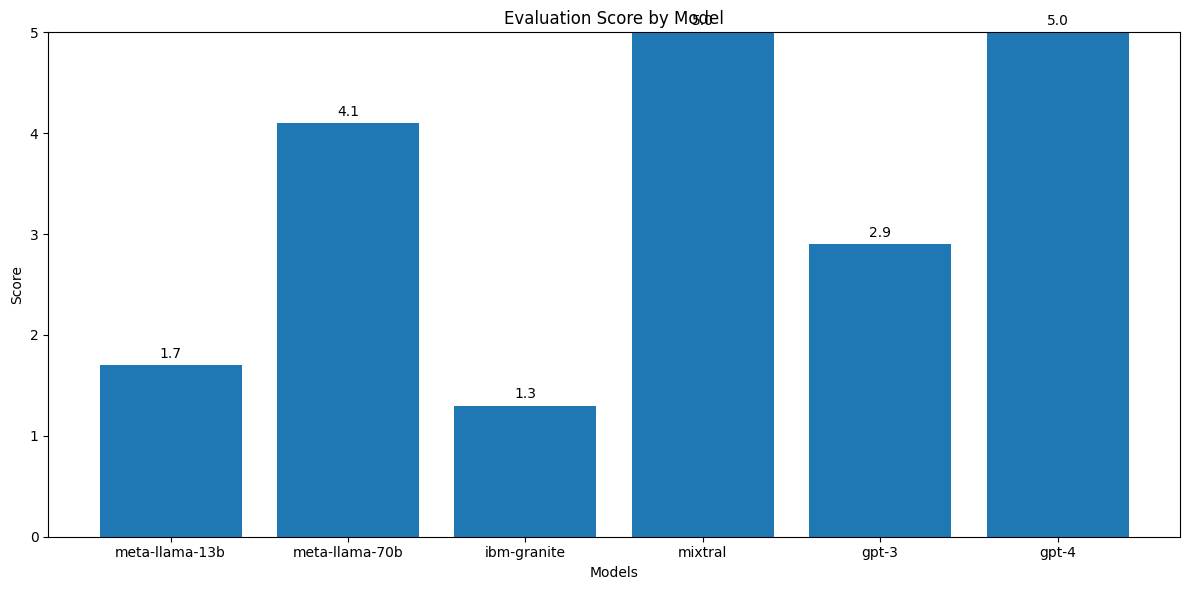

* meta-llama-13b
	1. The updated file addresses some issues but fails to fully migrate the JavaEE code to Quarkus. It replaces @Stateless with @ApplicationScoped and introduces Emitters, but doesn't retain the original functionality or imports.
	2. The updated file has significant syntactical issues. It's missing necessary imports, the Logger is removed, and the process method is not present. The added GET and POST methods are unrelated to the original functionality.
	3. While the file introduces some Quarkus-compatible elements like Emitters, it doesn't properly migrate the JMS functionality or retain the original ShoppingCart processing logic, making it unsuitable for direct use in Quarkus.
* meta-llama-70b
	1. Most issues are fixed, but the `@ApplicationScoped` annotation is missing, which was suggested to replace `@Stateless`.
	2. The file is syntactically valid and imports are correct. However, the `jakarta.jms.Destination` import is unused and can be removed.
	3. The updated file

In [68]:
plot_chart_and_print_reasoning(few_shot_hard_eval_output)

# Few Shot (LLM Summary)

In this section, we use a prompt that contains a summary of changes as solved examples. This summary will be generated by another LLM by looking at diffs of previous solved example. This differs from our last approach where we passed the diff directly to the LLM.

For the example we are using, a default data set is not present in Kai right now. Therefore, we will create these examples from diffs. We will use the exact same prompt Kai uses to generate the LLM summary of solved examples.

Lets create LLM summary for diffs we have as solved examples.

## Easy Example

The outputs of this experiment will be generated in `./data/outputs/using_kai/few_shot_easy_llm_summary/` directory for each model.

In [97]:
# run kai-fix for all models
for model in [META_LLAMA_13b]:
    print(f"generating fix using model {model}")
    run_kai_generate_fix(model, "few_shot_easy_llm_summary", "./templates/few_shot/default.jinja", EXAMPLE_EASY, llm_summary=True)
    print(f"generated fix using model {model}, output present in {OUTPUT_BASE_PATH}/using_kai/few_shot_easy_llm_summary/{model}")

generating fix using model meta-llama-13b
generated fix using model meta-llama-13b, output present in ./data/outputs//using_kai/few_shot_easy_llm_summary/meta-llama-13b


# Comparing evaluation outputs for different scenarios

In this section, we compare evaluation outputs we obtained from various different scenarios in previous sections. 

## Easy Example

For the easy example, we looked at doing a simple fix with Kai which involved updating a single import statement.

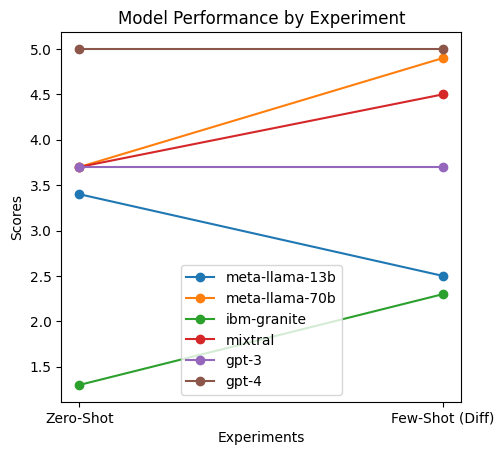

In [72]:
plot_multibar_chart_from_eval_outputs([
    (zero_shot_easy_eval_output, "Zero-Shot"), 
    # (zero_shot_easy_with_info_eval_output, "Zero-Shot w Info"), 
    (few_shot_easy_eval_output, "Few-Shot (Diff)")])

## Hard Example


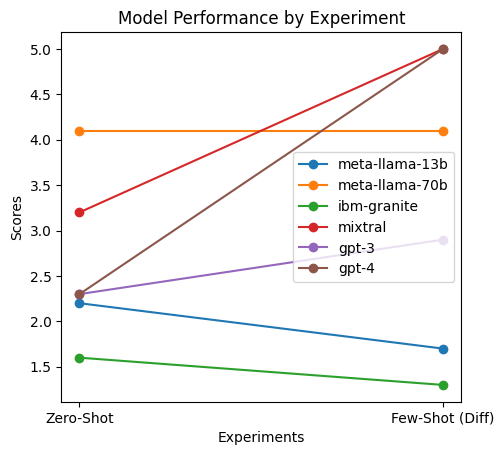

In [71]:

plot_multibar_chart_from_eval_outputs([
    (zero_shot_hard_eval_output, "Zero-Shot"), 
    # (zero_shot_hard_with_info_eval_output, "Zero-Shot w Info"),
    (few_shot_hard_eval_output, "Few-Shot (Diff)")
    ]) 

## Learnings

1. Few Shot prompts work as long as the underlying model is trained with code for target technology. The accuracy of fixes degrades as files become larger, and/or fixes become more complex. 

2. Few Shot prompts require additional analysis information to work a little better. However, merely including line numbers in the prompt is not going to help. A text description about an issue that hints about a possible solution is way better than line numbers. 

3. 